In [185]:
# https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html

# Text preprocessing
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os
import unicodedata
import string

# Model/Train Helpers
import random
import time
import math
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker



# PyTorch
import torch
import torch.nn as nn

# Character-Level RNN for Classifying Name Origins

## Collecting Data

In [11]:
def findFiles(path): return glob.glob(path)
print(findFiles('./data/rnn_tut_data/names/*.txt'))

['./data/rnn_tut_data/names\\Arabic.txt', './data/rnn_tut_data/names\\Chinese.txt', './data/rnn_tut_data/names\\Czech.txt', './data/rnn_tut_data/names\\Dutch.txt', './data/rnn_tut_data/names\\English.txt', './data/rnn_tut_data/names\\French.txt', './data/rnn_tut_data/names\\German.txt', './data/rnn_tut_data/names\\Greek.txt', './data/rnn_tut_data/names\\Irish.txt', './data/rnn_tut_data/names\\Italian.txt', './data/rnn_tut_data/names\\Japanese.txt', './data/rnn_tut_data/names\\Korean.txt', './data/rnn_tut_data/names\\Polish.txt', './data/rnn_tut_data/names\\Portuguese.txt', './data/rnn_tut_data/names\\Russian.txt', './data/rnn_tut_data/names\\Scottish.txt', './data/rnn_tut_data/names\\Spanish.txt', './data/rnn_tut_data/names\\Vietnamese.txt']


In [9]:
# All letters in the vocabulary
all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)
print(all_letters)
print(f"{n_letters = }")

abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ .,;'
n_letters = 57


In [17]:
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )    

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]


# example
unicodeToAscii('Ślusàrski')

'Slusarski'

In [66]:
# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []
for filename in findFiles('data/rnn_tut_data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)
print(f"{n_categories = }")

category_lines['Italian'][:10]


n_categories = 18


['Abandonato',
 'Abatangelo',
 'Abatantuono',
 'Abate',
 'Abategiovanni',
 'Abatescianni',
 'Abba',
 'Abbadelli',
 'Abbascia',
 'Abbatangelo']

## Data -> Tensors

In [135]:
def letterToIndex(letter):
    return all_letters.find(letter)

def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1 ##index the letter in the onehot-encoding
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print( letterToTensor("J") )
print( (lineToTensor("Hello")).shape )


tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([5, 1, 57])


## Helper Functions

In [68]:
def categoryFromOutput(output):
    """Decode model output into category prediction"""
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

In [69]:
def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    """Randomly pick training examples"""
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)


category = Russian / line = Yakunichev
category = Vietnamese / line = Doan
category = Italian / line = Alunni
category = Spanish / line = Rodriquez
category = Dutch / line = Stoep
category = Irish / line = Rinn
category = Scottish / line = Sinclair
category = Vietnamese / line = Ly
category = English / line = Goodridge
category = English / line = Noonan


## RNN



In [70]:
"""
Basic RNN Diagram


[input]          [hidden]<---
    |_____      _____|      |
          |    |            |
        [combined (cat)]    |
    _____|          |       |
   |                |       |
  (i2o)            (i2h)    |      (Linear NN 'hidden layers')
   |                |       |       (could apply an activation function)
[softmax]           |       |
   |                ⬇       |       
   ⬇             [hidden]--->
[OUTPUT]

"""

'\nBasic RNN Diagram\n\n\n[input]          [hidden]<---\n    |_____      _____|      |\n          |    |            |\n        [combined (+)]      |\n    _____|          |       |\n   |                |       |\n  (i2o)            (i2h)    |      (Linear NN layers)\n   |                |       |\n[softmax]           |       |\n   |                ⬇       |       \n   ⬇             [hidden]--->\n[OUTPUT]\n\n'

In [314]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size
        self.i2h = nn.Linear(in_features = input_size + hidden_size, 
                            out_features = hidden_size)
        self.i2o = nn.Linear(in_features = input_size + hidden_size,
                            out_features = output_size)
        self.tanh = nn.Tanh()
        self.softmax = nn.LogSoftmax(dim=1)

        # reinitialize weights if recalling __init__
        self.apply(self._init_weights)
    
    def forward(self, input, hidden):
        """Concatenate the inputs with the hidden state and forward pass through the linear layers (+ softmax)."""
        combined = torch.cat((input, hidden), dim=1)
        hidden = self.tanh(self.i2h(combined))
        output = self.softmax(self.i2o(combined))
        return output, hidden

    def init_hidden(self):
        """initialization for the hidden state with the zero vector."""
        return torch.zeros(1, self.hidden_size)
    

    def _init_weights(self, module):
        """Reinitialize weights and biases."""
        if isinstance(module, nn.Linear):
            torch.nn.init.xavier_uniform_(module.weight.data) ##since using tanh
            if module.bias is not None:
                module.bias.data.zero_()

In [316]:
# DEFINE MODEL (decided to use 2 RNN layers)
torch.manual_seed(12345)
n_hidden = 128

rnn0 = RNN(input_size=n_letters, hidden_size=n_hidden, output_size=n_categories)
# rnn1 = RNN(input_size=n_hidden, hidden_size=n_hidden, output_size=n_categories) ##input needs to match output of last layer




# Example output
print("> Albert")
input = lineToTensor("Albert")
hidden0 = torch.zeros(1, n_hidden)
hidden1 = torch.zeros(1, n_hidden)

output0, next_hidden0 = rnn0(input[0], hidden0)
# output, next_hidden1  = rnn1(output0, hidden1)
output = output0

print(output.shape) ##1 x n_categories, where every category is the likelihood of that category.
print(categoryFromOutput(output)) ## decoded prediction


> Albert
torch.Size([1, 18])
('Russian', 14)


In [317]:
params = 0
for p in rnn0.parameters():
    params += p.nelement()
params * 1

27156

In [318]:
# Create a train function (one training step)

def train_step(category_tensor, line_tensor, criterion, lr):
    """Perform one forward and backward pass, and update model's weights."""
    
    # Initialize the hidden states (with zeros)
    hidden0 = rnn0.init_hidden() 
    # hidden1 = rnn1.init_hidden()

    # Zero and gradients
    rnn0.zero_grad()
    # rnn1.zero_grad()

    # FORWARD PASS
    for i in range(line_tensor.shape[0]):
        # FEED IN EACH CHARACTER OF THE LINE
        ## GET THE OUTPUT AND THE NEW HIDDEN STATE
        output0, hidden0 = rnn0(line_tensor[i], hidden0)
        # output1, hidden1 = rnn1(output0, hidden1)
        output = output0
    
    # BACKWARD PASS
    loss = criterion(output, category_tensor) ##provide the model's output (predicted categories) and the true categories
    loss.backward() #backprop

    # UPDATE
    for p in rnn0.parameters():
        p.data += -lr * p.grad
    # for p in rnn1.parameters():
    #     p.data += -lr * p.grad

    return output, loss.item()

## training loop

In [271]:
category_lines['Italian'][:1]

['Abandonato']

In [319]:
lr = 0.03

n_iters = 10_000
print_every = 1000
plot_every = 100

current_loss = 0
all_losses = []


def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [320]:
loss_fn = nn.NLLLoss()
test_1_sample = True

start = time.time()
for iter in range(1, n_iters+1):
    # Get a batch (a random training example)
    category, line, category_tensor, line_tensor = randomTrainingExample()
    if test_1_sample:
        category, line = "Italian", "Abandonato"
        line_tensor = lineToTensor(line)
        category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)

    # Perforam a train step and record loss
    output, loss = train_step(category_tensor, line_tensor, lr=lr, criterion=loss_fn)
    current_loss += loss

    # print updates
    if (iter % print_every) == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if (iter % plot_every) == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

1000 10% (0m 2s) 0.0004 Abandonato / Italian ✓
2000 20% (0m 4s) 0.0002 Abandonato / Italian ✓
3000 30% (0m 6s) 0.0001 Abandonato / Italian ✓
4000 40% (0m 8s) 0.0001 Abandonato / Italian ✓
5000 50% (0m 11s) 0.0001 Abandonato / Italian ✓
6000 60% (0m 13s) 0.0001 Abandonato / Italian ✓
7000 70% (0m 16s) 0.0000 Abandonato / Italian ✓
8000 80% (0m 18s) 0.0000 Abandonato / Italian ✓
9000 90% (0m 21s) 0.0000 Abandonato / Italian ✓
10000 100% (0m 23s) 0.0000 Abandonato / Italian ✓


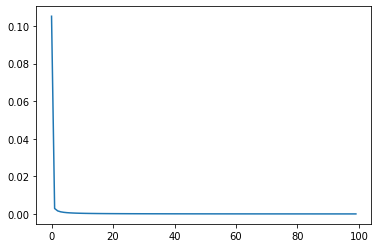

In [321]:
plt.plot(all_losses)
plt.show()

# Confusion Matrix

In [292]:
# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn0.init_hidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn0(line_tensor[i], hidden)

    return output



In [ ]:
# Keep track of correct guesses in a confusion matrix (2x2 torch tensor)
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()


# Set up plot
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# # Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

# User Input

In [293]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

In [322]:
predict('Dovesky')
predict('Jackson')
predict('Satoshi')
predict('Abandonato')


> Dovesky
(-0.00) Italian
(-9.48) Arabic
(-9.50) Dutch

> Jackson
(-0.00) Italian
(-9.78) Polish
(-9.90) Japanese

> Satoshi
(-0.00) Italian
(-9.30) Polish
(-9.45) Japanese

> Abandonato
(-0.00) Italian
(-12.71) Polish
(-12.72) English
